In [1]:
from obspy import read
import matplotlib.pyplot as plt
from scipy import signal
import xarray as xr
import numpy as np

# Quick exploratory checks on data access

In this little tutorial, we'll walk through an example of how you might load data from the Ocean Observatories Initiative (OOI). In particular we'll focus on data from a broadband hydrophone that's part of the seismic instrumentation package at Axial Seamount. 

*note: if you'd like to follow along you'll need to request access to [OOI-JupyterHub](https://jupyter.oceanobservatories.org/)*

## Find a file 

The specific instrument I chose is "RS03AXBS-LJ03A-09-HYDBBA302". Let me break that down:

- RS means Regional Scale Nodes - a cabled observatory off Oregon
- 03 a numerical identifier for the node
- AXBS - Axial Base Seafloor instrument
- LJ03A - Low-power JBox
- HYDBBA - broadband hydrophone

Note that the broadband hydrophone files are in "miniseed" format, which is generally used to store seismic data. There's a great library for parsing these, called obspy - https://docs.obspy.org/. 

In the next cell, I've provided the path to just one single 5-minute file. I didn't entirely pick this at random - it's from January, which I know is a good bet if you're trying to see some fin whale calls in the NE Pacific.

In [5]:
file = "../../ooi/san_data/RS03AXBS-LJ03A-09-HYDBBA302/2024/01/05/" + \
       "OO-AXVM1--YDH-2024-01-05T02:30:00.000000Z.mseed"


In [6]:
# Read in the miniseed file as a data stream (using Obspy)
stream = read(file)

In [7]:
# What's in the stream?
stream

601 Trace(s) in Stream:

OO.AXVM1..YDH | 2024-01-05T02:30:00.000000Z - 2024-01-05T02:30:00.599984Z | 64000.0 Hz, 38400 samples
...
(599 other traces)
...
OO.AXVM1..YDH | 2024-01-05T02:34:59.850000Z - 2024-01-05T02:34:59.999984Z | 64000.0 Hz, 9600 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

## Decimation, and more decimation

I decimated this data so that it has an effective sample rate of 400 Hz. This is more than enough for the 20Hz fin whale calls - Nyquist says we'll be able to resolve signal components up to 200 Hz.

In [14]:
dat0 = stream.detrend().split().decimate(16).merge(method=1, fill_value="interpolate").decimate(10)
dat = dat0[0].data
dat

array([ 0.00000000e+00, -6.19434583e-01, -1.24777904e+01, ...,
       -2.66484452e+02,  1.62062147e+02,  8.08964345e+02])

400.0

## Custom spectrogram

In [9]:
fs = 400

# Set spectrogram parameters
segment_length_seconds = .5
nperseg = int(segment_length_seconds * fs)
#nperseg = None
noverlap_percent = 15
noverlap = int(nperseg * noverlap_percent/100)
#noverlap = None

f, t, Sxx = signal.spectrogram(dat, fs, nperseg = nperseg, noverlap = noverlap)
#f, t, Sxx = signal.spectrogram(dat, fs)
Sxarray = xr.DataArray(np.log10(Sxx), 
                       dims=('frequency', 'time'),
                       coords={'frequency':f, 'time':t})

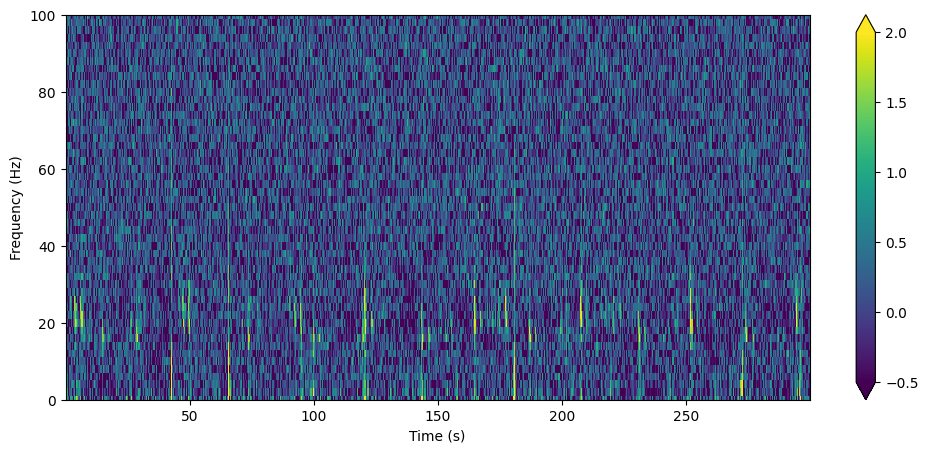

In [10]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
Sx_norm = Sxarray - Sxarray.mean(axis=1)
Sx_norm.plot(ax=ax, vmin=-.5, vmax=2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_ylim([0,100]);
